# <font style="color:blue">Project 3: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://www.dropbox.com/scl/fi/pswwraz1cc9srd9d4hxm3/data_montage.jpg?rlkey=074v9mc32et70ijl0dz3y0rvs&dl=1" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [2]:
import os
import json

# Путь к домашней директории пользователя
kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)




In [3]:
from dataclasses import dataclass
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 12
    IMG_WIDTH:   int = 960
    IMG_HEIGHT:  int = 512

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 10
    EPOCHS:          int = 100
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', 'UNet_CamVid_Dice_loss')
    NUM_WORKERS:     int = 3

@dataclass(frozen=True)
class InferenceConfig:
    BATCH_SIZE:  int = 4
    NUM_BATCHES: int = 2

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset

class SemSegDataset(Dataset):
    def __init__(self, data_path, image_ids, mode='train', transforms=None):
        """
        Args:
            data_path (str): Путь до корневой папки, внутри которой есть 'imgs/imgs' и 'masks/masks'.
            image_ids (list): Список имён файлов, например: ['1.png', '2.png']
            mode (str): 'train', 'val' или 'test'
            transforms (callable, optional): Преобразования для изображения и маски
        """
        self.data_path = data_path
        self.image_ids = image_ids
        self.mode = mode
        self.transforms = transforms
        self.num_classes = 12
        self.images_folder = os.path.join(data_path, 'imgs', 'imgs')
        self.masks_folder = os.path.join(data_path, 'masks', 'masks')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        file_id = self.image_ids[idx]
        img_path = os.path.join(self.images_folder, f'{file_id}.jpg')
        image = Image.open(img_path).convert('RGB')

        if self.mode != 'test':
            mask_path = os.path.join(self.masks_folder, f'{file_id}.png')
            mask = Image.open(mask_path).convert('L')

        # ✅ Преобразуем в NumPy массив перед передачей в albumentations
            image_np = np.array(image)
            mask_np = np.array(mask)

            if self.transforms:
                transformed = self.transforms(image=image_np, mask=mask_np)
                image = transformed['image']         # Tensor
                mask = transformed['mask'].long()    # Tensor
            else:
                image = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.
                mask = torch.from_numpy(mask_np).long()

            return image, mask

        else:
            image_np = np.array(image)
            if self.transforms:
                image = self.transforms(image=image_np)['image']
            else:
                image = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.
            return image, file_id


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose([
        # ─ геометрия ─
        A.RandomResizedCrop(
            size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
            scale=(0.5, 1.0), ratio=(1.0, 2.0), p=1.0),
        A.RandomRotate90(p=0.3),
        A.HorizontalFlip(p=0.5),

        # ─ цвет & размытие ─
        A.ColorJitter(0.4, 0.4, 0.4, 0.1, p=0.8),
        A.GaussianBlur(blur_limit=3, p=0.2),

        # ─ гарантия одинакового итогового размера ─
        A.Resize(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, always_apply=True),

        # ─ нормализация и ToTensor ─
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std =(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transforms():
    return A.Compose([
        A.Resize(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std =(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

/home/miroslavm/miniforge3/envs/plantseg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
image_dir = "/storage01/miroslavm/Test/opencv_segmentation/imgs/imgs"
mask_dir = "/storage01/miroslavm/Test/opencv_segmentation/masks/masks"

# Собираем ID без расширений
image_ids = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg")}
mask_ids  = {os.path.splitext(f)[0] for f in os.listdir(mask_dir) if f.endswith(".png")}

# Только те, у кого есть и картинка и маска
valid_ids = sorted(image_ids & mask_ids)

# Разделим вручную (80% train, 20% val)
random.seed(42)
random.shuffle(valid_ids)
split_idx = int(0.8 * len(valid_ids))
train_ids = valid_ids[:split_idx]
val_ids = valid_ids[split_idx:]
print(f"Total valid: {len(valid_ids)}")
print(f"Train: {len(train_ids)} | Val: {len(val_ids)}")
train_dataset = SemSegDataset(
    data_path='/storage01/miroslavm/Test/opencv_segmentation',
    image_ids=train_ids,
    mode='train',
    transforms=get_train_transforms()
)

val_dataset = SemSegDataset(
    data_path='/storage01/miroslavm/Test/opencv_segmentation',
    image_ids=val_ids,
    mode='val',
    transforms=get_val_transforms()
)


Total valid: 2621
Train: 2096 | Val: 525


/tmp/ipykernel_1137550/3941566422.py:18: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, always_apply=True),


## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

In [7]:
def denormalize(tensor_img):
    # Обратная нормализация (используется mean/std из transforms)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = tensor_img.permute(1, 2, 0).cpu().numpy()  # C,H,W → H,W,C
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

(-0.5, 959.5, 511.5, -0.5)

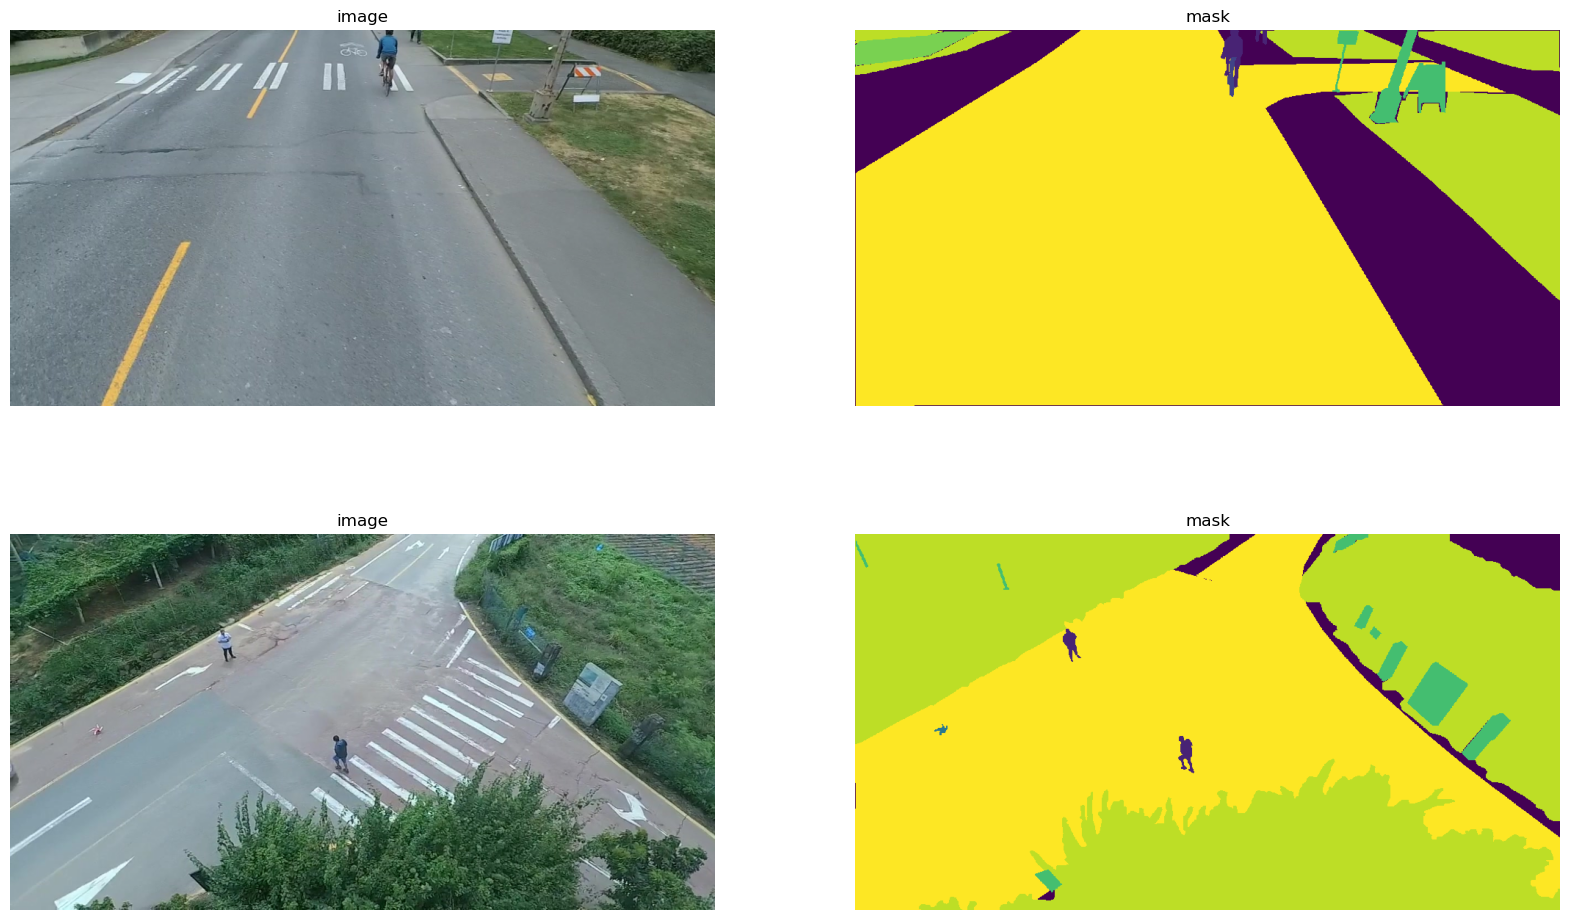

In [7]:
import matplotlib.pyplot as plt
img0, mask0 = val_dataset[0]
img1, mask1 = val_dataset[1]
img0 = denormalize(img0)
img1 = denormalize(img1)
mask0 = mask0.cpu().numpy()
mask1 = mask1.cpu().numpy()
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(img0)
ax1.title.set_text("image")
ax1.axis("off")
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("mask")
ax2.imshow(mask0)
plt.axis("off")
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(img1)
ax3.title.set_text("image")
ax3.axis("off")
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("mask")
ax4.imshow(mask1)
plt.axis("off")

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [8]:
import torch.nn as nn
class DiceCELoss(nn.Module):
    def __init__(self, class_weights, alpha=0.6, smooth=1e-5):
        """
        alpha — доля Dice-части (0‒1)
        """
        super().__init__()
        self.alpha   = alpha
        self.smooth  = smooth
        self.ce      = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, target):
        # CE-часть
        ce_loss = self.ce(logits, target)

        # Dice-часть
        n, c, h, w = logits.shape
        probs      = F.softmax(logits, dim=1)
        tgt_oh     = F.one_hot(target, num_classes=c).permute(0,3,1,2).float()

        inter = (probs * tgt_oh).sum((2,3))
        union = probs.sum((2,3)) + tgt_oh.sum((2,3))
        dice  = (2*inter + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        return self.alpha * dice_loss + (1-self.alpha) * ce_loss

In [9]:
def mean_iou(predictions, ground_truths, num_classes=12, dims = (1, 2)):
    """
    Arguments:
    predictions (torch.tensor): Prediction (P) from the model with or without softmax.
                                Shape: [batch_size(B), height(H), width(W)]

    ground_truths (torch.tensor): Ground truth mask (G). Shape: [B, H, W]

    dims (tuple): Dimensions corresponding to image height and width in a tensor shape: [B, H, W, C].

    Returns:
    torch.tensor: A scalar tensor representing the Classwise Mean IoU metric.
    """

    # Convert single channel ground truth masks into one-hot encoded tensor.
    # Shape: [B, H, W] --> [B, H, W, num_classes]
    ground_truths = F.one_hot(ground_truths, num_classes=num_classes)

    # Converting unnormalized predictions into one-hot encoded across channels.
    # Shape: [B, H, W] --> [B, H, W, num_classes]
    predictions = F.one_hot(predictions, num_classes=num_classes)

    # Intersection: |G ∩ P|. Shape: [B, num_classes]
    intersection = (predictions * ground_truths).sum(dim=dims)

    # Summation: |G| + |P|. Shape: [B, num_classes].
    summation = (predictions.sum(dim=dims) + ground_truths.sum(dim=dims))

    # Union. Shape: [B, num_classes]
    union = summation - intersection

    # IoU Shape: [B, num_classes]
    iou = intersection / union

    # As no smoothing is used we replace any 'nan' value that with 0.
    # With smoothing the results yields slightly different values.
    iou = torch.nan_to_num(iou, nan=0.0)

    # Shape: [batch_size,]
    num_classes_present = torch.count_nonzero(summation, dim=1)

    # IoU per image.
    # Average over the total number of classes present in ground_truths and predictions.
    # Shape: [batch_size,]
    iou = iou.sum(dim=1) / num_classes_present

    # Compute the mean over the remaining axes (batch and classes).
    # Shape: Scalar
    iou_mean = iou.mean()

    return iou_mean

In [10]:
from sklearn.metrics import jaccard_score

def calculate_iou_per_class(y_true, y_pred, num_classes=12):
    ious = []
    for cls in range(num_classes):
        y_true_cls = (y_true == cls).astype(int).flatten()
        y_pred_cls = (y_pred == cls).astype(int).flatten()
        iou = jaccard_score(y_true_cls, y_pred_cls, zero_division=0)
        ious.append(iou)
    return ious

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [11]:
import gc
import os
import shutil
import zipfile
import warnings
from glob import glob
from dataclasses import dataclass
import torchvision.models as models
import cv2
import requests
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch

from torch.cuda import amp
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from torchinfo import summary

In [12]:
def calc_class_weights_from_masks(masks_folder, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith(".png")]
    for fname in tqdm(mask_files, desc="Counting pixels"):
        m = cv2.imread(os.path.join(masks_folder, fname), cv2.IMREAD_GRAYSCALE)
        for c in range(num_classes):
            counts[c] += np.sum(m == c)
    inv_freq = 1.0 / (counts / counts.sum())
    normed   = inv_freq / inv_freq.max()            # нормировка 0‒1
    return torch.tensor(normed, dtype=torch.float32)

CLASS_WEIGHTS = calc_class_weights_from_masks(
    masks_folder=os.path.join('/storage01/miroslavm/Test/opencv_segmentation',
                              'masks', 'masks'),
    num_classes=DatasetConfig.NUM_CLASSES).to('cuda')

Counting pixels: 100%|█████████████████████████████████████████| 2621/2621 [00:15<00:00, 173.79it/s]


In [13]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
class DeepLabEffB4(nn.Module):
    """
    DeepLabV3+  •  Encoder: EfficientNet-B4 (timm) •  Decoder: ASPP + upsample
    Возвращаем ТОЛЬКО главные логиты (без aux): (main_logits,)
    """
    def __init__(self, num_classes: int = 12):
        super().__init__()
        self.net = smp.DeepLabV3Plus(
            encoder_name='timm-efficientnet-b4',   # ↳ любой timm-энкодер
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None,                      # logits!
        )

    def forward(self, x):
        return (self.net(x), )

In [14]:
# class DoubleConv(nn.Module):
#     """Conv → GN → ReLU → Dropout → Conv → GN → ReLU"""
#     def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.1):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(inplace=True),
#             nn.Dropout2d(dropout),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class AttentionGate(nn.Module):
#     """
#     Gating signal (from decoder) + skip-connection (from encoder) → spatial attention mask.
#     """
#     def __init__(self, F_g, F_l, F_int):
#         super().__init__()
#         self.W_g = nn.Sequential(
#             nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
#             nn.GroupNorm(8, F_int),
#         )
#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
#             nn.GroupNorm(8, F_int),
#         )
#         self.psi = nn.Sequential(
#             nn.ReLU(inplace=True),
#             nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
#             nn.Sigmoid(),
#         )

#     def forward(self, g, x):
#         g1 = self.W_g(g)
#         x1 = self.W_x(x)
#         psi = self.psi(g1 + x1)
#         return x * psi


# class ASPP(nn.Module):
#     """Atrous Spatial Pyramid Pooling (à la DeepLabV3)"""
#     def __init__(self, in_channels, out_channels, rates=(1, 6, 12, 18)):
#         super().__init__()
#         self.blocks = nn.ModuleList([
#             nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, 1 if r == 1 else 3,
#                           padding=0 if r == 1 else r, dilation=r, bias=False),
#                 nn.GroupNorm(8, out_channels),
#                 nn.ReLU(inplace=True),
#             ) for r in rates
#         ])
#         self.project = nn.Sequential(
#             nn.Conv2d(len(rates) * out_channels, out_channels, kernel_size=1, bias=False),
#             nn.GroupNorm(8, out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         res = torch.cat([b(x) for b in self.blocks], dim=1)
#         return self.project(res)


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, skip_channels, out_channels):
#         super().__init__()
#         self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
#         self.att = AttentionGate(F_g=out_channels, F_l=skip_channels, F_int=out_channels // 2)
#         self.conv = DoubleConv(in_channels=out_channels + skip_channels, out_channels=out_channels)

#     def forward(self, x, skip):
#         x = self.up(x)
#         x = TF.resize(x, size=skip.shape[2:])        # safety-resize
#         skip = self.att(x, skip)
#         x = torch.cat([x, skip], dim=1)
#         return self.conv(x)

# # ────────────────────────────────
# # UNet with ResNet-34 encoder + ASPP + attention decoder
# # ────────────────────────────────
# class UNet(nn.Module):
#     def __init__(self, num_classes: int = 12):
#         super().__init__()

#         backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

#         # ------- encoder -------
#         self.enc_1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)  # 64,  H/2
#         self.pool1 = nn.MaxPool2d(2)                                             #      H/4
#         self.enc_2 = backbone.layer1                                             # 64
#         self.enc_3 = backbone.layer2                                             # 128
#         self.enc_4 = backbone.layer3                                             # 256
#         self.enc_5 = backbone.layer4                                             # 512

#         # ------- bottleneck -------
#         self.intermediate = ASPP(in_channels=512, out_channels=256)

#         # ------- decoder -------
#         self.dec_1 = DecoderBlock(in_channels=256, skip_channels=256, out_channels=256)
#         self.dec_2 = DecoderBlock(in_channels=256, skip_channels=128, out_channels=128)
#         self.dec_3 = DecoderBlock(in_channels=128, skip_channels=64,  out_channels=64)
#         self.dec_4 = DecoderBlock(in_channels=64,  skip_channels=64,  out_channels=32)
        
#         self.aux_head = nn.Conv2d(128, num_classes, kernel_size=1)
#         # ------- head -------
#         self.conv_1x1 = nn.Conv2d(32, num_classes, kernel_size=1)

#     # keep same forward variable names (enc_1 … dec_4)
#     def forward(self, x):
#         enc_1 = self.enc_1(x)            # [B, 64, H/2, W/2]
#         x     = self.pool1(enc_1)        # [B, 64, H/4, W/4]

#         enc_2 = self.enc_2(x)            # [B, 64, H/4, W/4]
#         enc_3 = self.enc_3(enc_2)        # [B,128, H/8, W/8]
#         enc_4 = self.enc_4(enc_3)        # [B,256, H/16,W/16]
#         enc_5 = self.enc_5(enc_4)        # [B,512, H/32,W/32]

#         inter = self.intermediate(enc_5) # [B,256, H/32,W/32]

#         up_1  = self.dec_1(inter, enc_4) # [B,256, H/16,W/16]
#         up_2  = self.dec_2(up_1, enc_3)  # [B,128,H/8,W/8]
#         aux   = self.aux_head(up_2)      #   ↳ low-res logits
        
#         up_3  = self.dec_3(up_2, enc_2)
#         up_4  = self.dec_4(up_3, enc_1)
#         out   = F.interpolate(up_4, scale_factor=2, mode='bilinear', align_corners=False)
#         out   = self.conv_1x1(out)
#         return out, aux

In [14]:


model = DeepLabEffB4(num_classes=DatasetConfig.NUM_CLASSES)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(1, 3, DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH))

Layer (type:depth-idx)                                       Output Shape              Param #
DeepLabEffB4                                                 [1, 12, 512, 960]         --
├─DeepLabV3Plus: 1-1                                         [1, 12, 512, 960]         --
│    └─EfficientNetEncoder: 2-1                              [1, 3, 512, 960]          806,400
│    │    └─Conv2d: 3-1                                      [1, 48, 256, 480]         1,296
│    │    └─BatchNormAct2d: 3-2                              [1, 48, 256, 480]         96
│    │    └─Sequential: 3-3                                  --                        16,740,824
│    └─DeepLabV3PlusDecoder: 2-2                             [1, 256, 128, 240]        --
│    │    └─Sequential: 3-4                                  [1, 256, 32, 60]          984,640
│    │    └─UpsamplingBilinear2d: 3-5                        [1, 256, 128, 240]        --
│    │    └─Sequential: 3-6                                  [1, 48, 128, 

In [17]:

# 1. путь к чекпойнту
ckpt_dir  = TrainingConfig.CHECKPOINT_DIR          # тот же, что и при обучении
ckpt_name = "epoch_100.pth"                        # файл-весов
ckpt_path = os.path.join(ckpt_dir, ckpt_name)

# ─────────────────────────────────────────────────────────
# 2. создать модель той же архитектуры
model = DeepLabEffB4(num_classes=DatasetConfig.NUM_CLASSES).to(device)

# ─────────────────────────────────────────────────────────
# 3. загрузить веса
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict, strict=True)     # strict=True 👉 гарантия совпадения ключей

print(f"Checkpoint «{ckpt_name}» загружен ✅")


Checkpoint «epoch_100.pth» загружен ✅


# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


In [17]:
def train_one_epoch(
    model,
    loader,
    optimizer,
    scaler,
    num_classes,
    device="cuda",
    epoch_idx= 800,
    total_epochs=50,
):

    # Change model mode.
    model.train()

    loss_record   = MeanMetric()
    metric_record = MeanMetric()
    acc_record    = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                main_logits, = model(data)
            
                # апсемплируем aux → H,W таргета
                # aux_logits_up = F.interpolate(
                #     aux_logits,
                #     size=target.shape[1:],        # (H, W)
                #     mode='bilinear',
                #     align_corners=False
                # )
            
                #loss = criterion(main_logits, target) +  0.4 * criterion(aux_logits_up, target)
                loss = criterion(main_logits, target)
            if epoch > swa_start:
                swa_model.update_parameters(model)
                swa_scheduler.step()
            else:
                scheduler.step()
            # Calculate gradients w.r.t training parameters on scaled loss.
            scaler.scale(loss).backward()

            # Update parameters using gradients
            scaler.step(optimizer)

            # Updates the scale for the next iteration.
            scaler.update()

            # Detach the output "logits" tensor from the graph.
            logits = main_logits.detach()

            # Get the index across channel axis of the max logit score.
            # We can directly call argmax because: Softmax(logit).argmax() == logit.argmax()
            pred_idx = logits.argmax(dim=1)

            # Calculate Segmentation specific metric (Dice or IoU).
            metric = mean_iou(pred_idx, target, num_classes=num_classes)

            # Record and calculate batch accuracy using torchmetrics.
            acc_record.update(pred_idx.cpu(), target.cpu())


            loss_record.update(loss.detach().cpu(), weight=data.shape[0])
            metric_record.update(metric.cpu(),      weight=data.shape[0])

            tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, IoU: {metric_record.compute():.4f}, Acc: {acc_record.compute():.4f}")
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
    torch.save(swa_model.module.state_dict(), "model_swa.pth")
    # Get mean loss, accuracy and IoU score.
    epoch_loss   = loss_record.compute()
    epoch_metric = metric_record.compute()
    epoch_acc    = acc_record.compute()

    return epoch_loss, epoch_metric, epoch_acc

In [18]:
def validate(
    model,
    loader,
    device,
    num_classes,
    epoch_idx,
    total_epochs,
):
    model.eval()

    loss_record   = MeanMetric()
    metric_record = MeanMetric()
    acc_record    = MulticlassAccuracy(num_classes=num_classes, average="micro")

    class_iou_sums = np.zeros(num_classes)
    class_counts   = np.zeros(num_classes)

    loader_len = len(loader)

    with tqdm(total=loader_len, ncols=122) as tq:
        tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in loader:
            tq.update(1)

            data, target = data.to(device), target.to(device)

            with torch.no_grad():
                #main_logits, aux_logits = model(data)
                main_logits, = model(data)
            # aux_logits_up = F.interpolate(
            #     aux_logits,
            #     size=target.shape[1:],
            #     mode='bilinear',
            #     align_corners=False
            # )
            
            #loss = criterion(main_logits, target) + \
            #       0.4 * criterion(aux_logits_up, target)
            loss = criterion(main_logits, target)
            pred_idx = main_logits.argmax(dim=1)

            
            # IoU по каждому классу
            pred_np = pred_idx.cpu().view(-1).numpy()
            target_np = target.cpu().view(-1).numpy()

            for cls in range(num_classes):
                pred_cls = (pred_np == cls)
                target_cls = (target_np == cls)
                inter = np.logical_and(pred_cls, target_cls).sum()
                union = np.logical_or(pred_cls, target_cls).sum()
                if union > 0:
                    class_iou_sums[cls] += inter / union
                    class_counts[cls] += 1

            metric = mean_iou(pred_idx, target, num_classes=num_classes)

            acc_record.update(pred_idx.cpu(), target.cpu())
            loss_record.update(loss.cpu(), weight=data.shape[0])
            metric_record.update(metric.cpu(), weight=data.shape[0])

        valid_epoch_loss   = loss_record.compute()
        valid_epoch_metric = metric_record.compute()
        valid_epoch_acc    = acc_record.compute()

        class_iou_avg = np.divide(
            class_iou_sums, class_counts,
            out=np.zeros_like(class_iou_sums),
            where=class_counts != 0
        )

        tq.set_postfix_str(
            s=f"Valid Loss: {valid_epoch_loss:.4f}, Valid IoU: {valid_epoch_metric:.4f}, Valid Acc: {valid_epoch_acc:.4f}"
        )

    return valid_epoch_loss, valid_epoch_metric, valid_epoch_acc, class_iou_avg

In [24]:
dataset_cfg = DatasetConfig()
train_cfg   = TrainingConfig()

In [25]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=train_cfg.NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=train_cfg.NUM_WORKERS
)



In [22]:
from torch.optim.swa_utils import AveragedModel, SWALR


optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=110, eta_min=1e-6)
swa_model = AveragedModel(model)
swa_start = 110          # эпоха, с которой начнём усреднение
swa_scheduler = SWALR(optimizer, swa_lr=1e-5)
scaler     = torch.cuda.amp.GradScaler()
criterion  = DiceCELoss(CLASS_WEIGHTS).to(device)


/tmp/ipykernel_1121669/4270770179.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler()


In [ ]:
train_losses = []
val_losses = []
val_ious = []

for epoch in range(1, train_cfg.EPOCHS + 1):
    train_loss, train_iou, _ = train_one_epoch(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        scaler=scaler,
        num_classes=dataset_cfg.NUM_CLASSES,
        device='cuda',
        epoch_idx=epoch,
        total_epochs=train_cfg.EPOCHS
        
    )

    val_loss, val_miou, val_acc, iou_per_class = validate(
        model=model,
        loader=val_loader,
        device='cuda',
        num_classes=dataset_cfg.NUM_CLASSES,
        epoch_idx=epoch,
        total_epochs=train_cfg.EPOCHS
    )

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    val_ious.append(val_miou.item())

    scheduler.step()

    # Save checkpoint
    os.makedirs(train_cfg.CHECKPOINT_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(train_cfg.CHECKPOINT_DIR, f"epoch_{epoch:03d}.pth"))

Train :: Epoch: 1/100:   0%|▎                                                             | 1/210 [00:00<03:05,  1.13it/s]/home/miroslavm/miniforge3/envs/plantseg/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Train :: Epoch: 1/100:   5%|█                    | 10/210 [00:08<02:37,  1.27it/s, Loss: 1.4558, IoU: 0.0424, Acc: 0.2341]

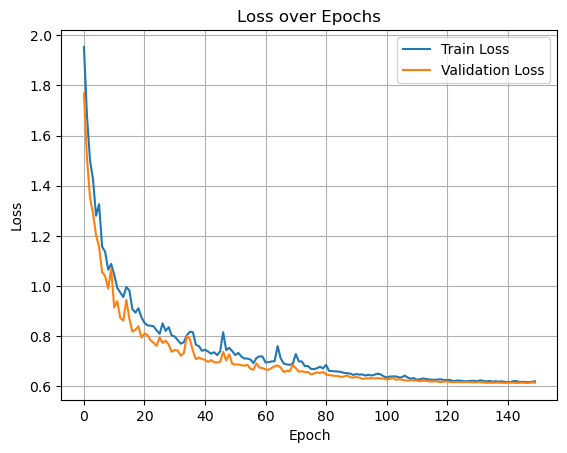

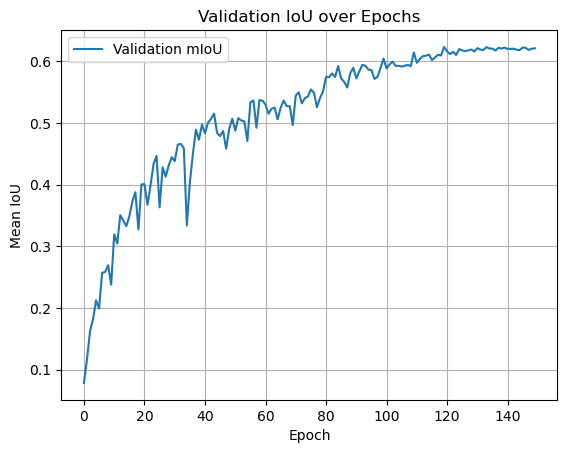

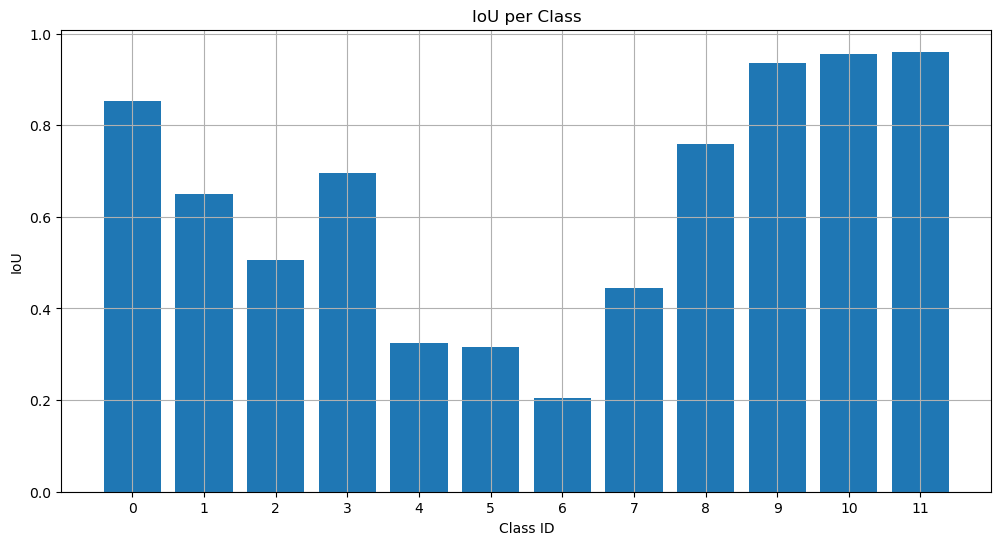

In [22]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_ious, label="Validation mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.title("Validation IoU over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(iou_per_class)), iou_per_class)
plt.xticks(np.arange(len(iou_per_class)))
plt.xlabel("Class ID")
plt.ylabel("IoU")
plt.title("IoU per Class")
plt.grid(True)
plt.show()

## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



In [ ]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None]
    return tensor * std + mean
def num_to_rgb(num_arr, color_map):
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
    return np.float32(output) / 255.0
def image_overlay(image, segmented_image):
    alpha, beta, gamma = 1.0, 0.7, 0.0
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.clip(image, 0.0, 1.0)

In [27]:
def generate_random_colormap(num_classes=12, seed=42):
    random.seed(seed)
    id2color = {
        i: tuple(random.choices(range(256), k=3))
        for i in range(num_classes)
    }
    return id2color
id2color = generate_random_colormap()

In [28]:
def predict_tta(model, x):
    with torch.no_grad():
        main, _ = model(x)
        # горизонтальный флип
        x_flip = torch.flip(x, dims=[3])
        main_flip, _ = model(x_flip)
        main_flip = torch.flip(main_flip, dims=[3])
        return (main + main_flip) / 2

In [29]:
def show_prediction_triplet(images, gt_masks, pred_masks, color_map, num_samples=3):
    def num_to_rgb(mask, color_map):
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for k, color in color_map.items():
            rgb[mask == k] = color
        return rgb

    for i in range(min(num_samples, len(images))):
        img = images[i]
        gt_mask = gt_masks[i]
        pred_mask = pred_masks[i]

        gt_rgb = num_to_rgb(gt_mask, color_map)
        pred_rgb = num_to_rgb(pred_mask, color_map)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_rgb)
        plt.title("ground-truth mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_rgb)
        plt.title("predicted mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

In [30]:
def denormalize_batch(tensor_bchw):
    """
    tensor_bchw: [B, 3, H, W] в диапазоне [-mean/std, …, +]
    → [B, 3, H, W] в диапазоне [0,1]
    """
    mean = torch.tensor([0.485, 0.456, 0.406],
                        device=tensor_bchw.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225],
                        device=tensor_bchw.device).view(1, 3, 1, 1)
    return tensor_bchw * std + mean

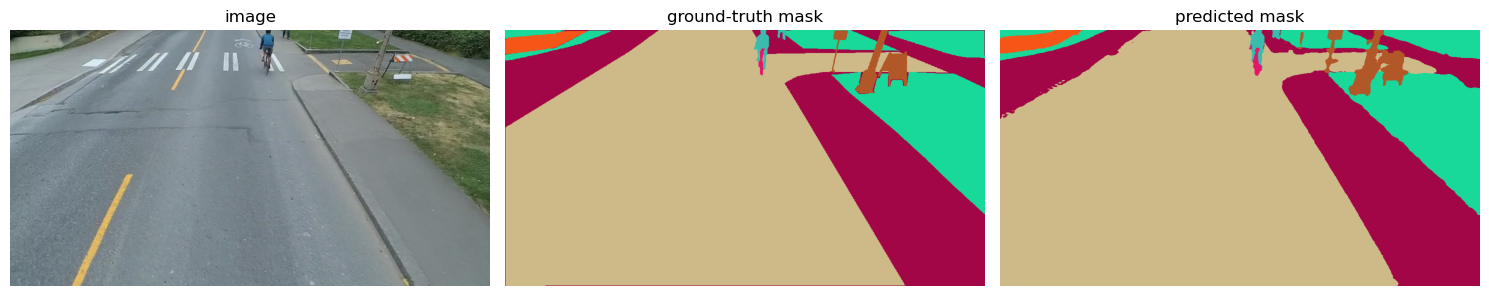

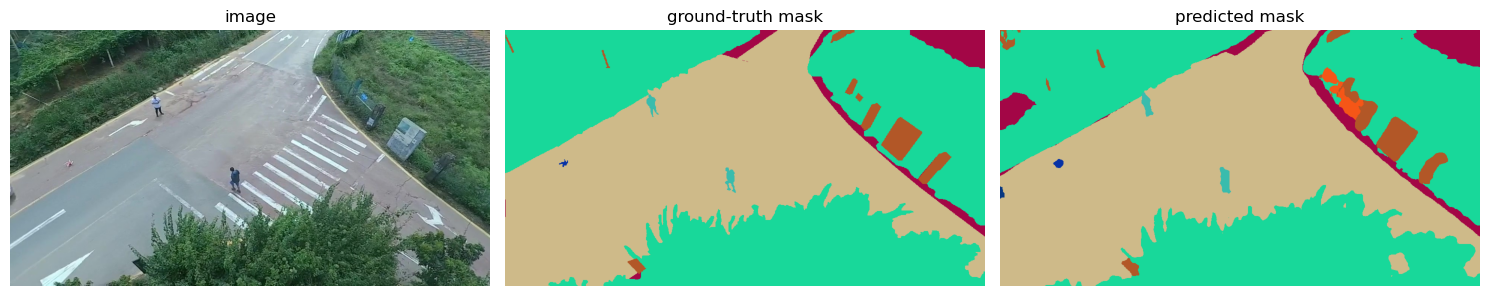

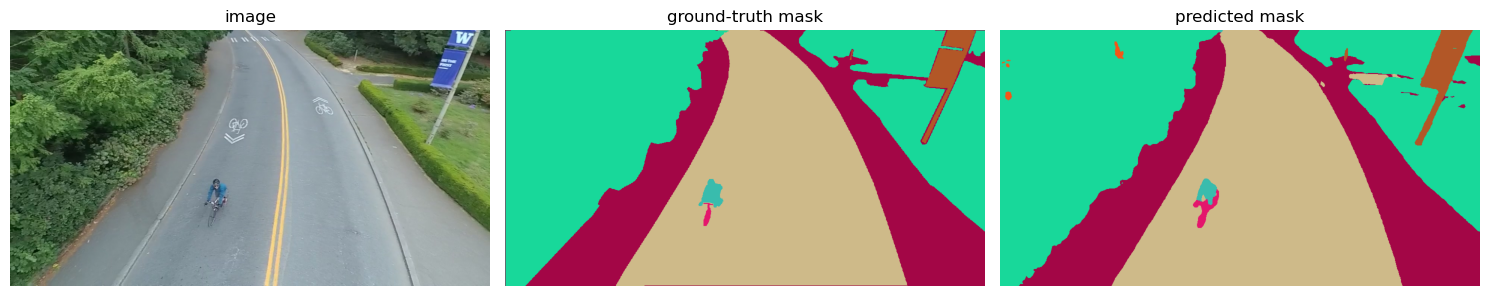

In [44]:
model.eval()
with torch.no_grad():
    for imgs, gts in val_loader:
        imgs = imgs.to(device)

        output = model(imgs)
        main_logits = output[0]  # извлекаем из кортежа
        preds = main_logits.argmax(dim=1).cpu().numpy()

        imgs_vis = denormalize_batch(imgs).permute(0, 2, 3, 1).cpu().numpy()
        gts_vis  = gts.numpy()

        show_prediction_triplet(imgs_vis, gts_vis, preds, color_map=id2color)
        break

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [35]:

import pandas as pd


data_path = '/storage01/miroslavm/Test/opencv_segmentation'
image_dir = os.path.join(data_path, 'imgs', 'imgs')

# 2. Загрузка test.csv
df_test = pd.read_csv(os.path.join(data_path, 'test.csv'))
df_test['ImageID'] = df_test['ImageID'].astype(str)

# 3. Собираем уникальные image_ids (без _classid)
image_ids = sorted(set(id_.split('_')[0] for id_ in df_test['ImageID']))

print(len(df_test))
print(len(image_ids))
# 3. Создаём тестовый датасет
test_dataset = SemSegDataset(
    data_path=data_path,
    image_ids=image_ids,
    mode='test',
    transforms=get_val_transforms()
)

648
648


In [36]:
def predict_tta_multiscale(model, x, scales=(0.75, 1.0, 1.25)):
    b, c, h0, w0 = x.shape
    with torch.no_grad():
        prob_sum = 0
        for s in scales:
            h, w = int(h0*s), int(w0*s)
            x_res  = F.interpolate(x, (h, w), mode='bilinear', align_corners=False)
            logits = model(x_res)[0]                         # main-head
            logits = F.interpolate(logits, (h0, w0), mode='bilinear', align_corners=False)

            # flip-branch
            x_flip   = torch.flip(x_res, dims=[3])
            log_flip = model(x_flip)[0]
            log_flip = torch.flip(log_flip, dims=[3])
            log_flip = F.interpolate(log_flip, (h0, w0), mode='bilinear', align_corners=False)

            prob_sum += torch.softmax(logits, dim=1) + torch.softmax(log_flip, dim=1)

        return prob_sum / (len(scales)*2)

In [37]:
def rle_encode(mask):
    """
    mask: 2-D np.uint8, 1-значения будут кодироваться
    Возвращает строку Run-Length Encoding в столбцовом ('F') порядке.
    """
    pixels = mask.flatten(order="F")
    pixels = np.concatenate([[0], pixels, [0]])    # sentinels
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))


# ───────────── sabmission, resize-back и TTA Prob-avg ─────────────
def generate_submission_multiclass(
        model,
        submission_df,
        image_dir,
        submission_path="submission.csv",
        num_classes=12,
        device="cuda"):

    model.eval()
    image_ids, encoded_pixels = [], []

    val_tf = get_val_transforms()      # один раз создаём трансформ

    with torch.no_grad(), tqdm(total=submission_df['ImageID'].nunique()) as bar:
        for image_id in submission_df['ImageID'].unique():
            bar.update(1)

            # 1) читаем и запоминаем исходный размер
            img_path = os.path.join(image_dir, f"{image_id}.jpg")
            img_bgr  = cv2.imread(img_path)
            if img_bgr is None:
                print(f"Missing: {img_path}")
                continue
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            H0, W0  = img_rgb.shape[:2]

            # 2) аугментация → tensor BCHW
            x = val_tf(image=img_rgb)['image'].unsqueeze(0).float().to(device)

            # 3) прогноз с TTA → вероятности
            logits = predict_tta_multiscale(model, x)           # (B=1, C, h, w)
            probs  = torch.softmax(logits, dim=1)[0] # убираем batch

            # 4) argmax и возврат к исходному разрешению
            pred_small = probs.argmax(0).cpu().numpy().astype(np.uint8)
            pred_full  = cv2.resize(pred_small, (W0, H0), interpolation=cv2.INTER_NEAREST)

            # 5) RLE для каждого класса
            for cid in range(num_classes):
                mask = (pred_full == cid).astype(np.uint8)
                rle  = rle_encode(mask)
                image_ids.append(f"{image_id}_{cid}")
                encoded_pixels.append(rle)

    pd.DataFrame({"ImageID": image_ids, "EncodedPixels": encoded_pixels})\
      .to_csv(submission_path, index=False)
    print(f"✅ Submission saved to «{submission_path}»")

In [39]:
generate_submission_multiclass(
    model=model,
    submission_df=df_test,
    image_dir=image_dir,
    submission_path="submission.csv",
    num_classes=12,
    device="cuda"
)


100%|█████████████████████████████████████████████████████████████| 648/648 [01:57<00:00,  5.52it/s]


✅ Submission saved to «submission.csv»


# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum dice score of `0.60` on the test data to get all points. If the dice score is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

In [ ]:
#https://www.kaggle.com/podtyazhki

In [40]:
!kaggle competitions submit -c opencv-pytorch-segmentation-project-round2 -f submission.csv -m "Another try"

100%|██████████████████████████████████████| 32.0M/32.0M [00:02<00:00, 13.8MB/s]
Successfully submitted to OpenCV PyTorch Segmentation Project Round 2